---
title: "基本的な因子分析のデモ  "
description: "因子分析の基本的な実装をfactor_analyzerを使って行う"
date: "2025-12-14"
categories: ["Statistics", "Factor Analysis", "Demo"]
jupyter: python3
---

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

# グラフのスタイル設定
sns.set(style='whitegrid')
# 注意: 日本語フォント設定は環境に合わせて調整してください（Colabの場合は別途インストールが必要）
# ここでは英語ラベルで進行しますが、意味は解説します。

# ダミーデータの作成

因子分析が綺麗に決まるよう、意図的に相関を持たせた健診データを作成します。  
 ここでは2つの潜在因子（1. 代謝・運動不足因子、2. ストレス・血圧因子）を想定してデータを生成します。

In [3]:
# 乱数シードの固定
np.random.seed(42)
n_samples = 500

# 潜在変数（真の要因）を作成
# Factor 1: 運動不足・肥満傾向 (Metabolic)
f_metabolic = np.random.normal(0, 1, n_samples)
# Factor 2: ストレス・交感神経緊張 (Stress)
f_stress = np.random.normal(0, 1, n_samples)

# 観測変数（健診項目）を作成
# 式: 観測値 = 負荷量 * 因子 + ノイズ
data = {
    # --- 因子1（代謝・肥満）の影響が強い項目 ---
    'BMI': 0.8 * f_metabolic + 0.1 * f_stress + np.random.normal(0, 0.5, n_samples),
    '腹囲(Waist)': 0.85 * f_metabolic + 0.1 * f_stress + np.random.normal(0, 0.5, n_samples),
    '中性脂肪(TG)': 0.7 * f_metabolic + 0.2 * f_stress + np.random.normal(0, 0.6, n_samples),
    '空腹時血糖(FPG)': 0.6 * f_metabolic + 0.3 * f_stress + np.random.normal(0, 0.6, n_samples),
    'HDLコレステロール': -0.7 * f_metabolic + np.random.normal(0, 0.6, n_samples), # 逆相関

    # --- 因子2（ストレス・血圧）の影響が強い項目 ---
    '収縮期血圧(SBP)': 0.2 * f_metabolic + 0.85 * f_stress + np.random.normal(0, 0.5, n_samples),
    '拡張期血圧(DBP)': 0.2 * f_metabolic + 0.80 * f_stress + np.random.normal(0, 0.5, n_samples),
    '脈拍(Pulse)': 0.1 * f_metabolic + 0.6 * f_stress + np.random.normal(0, 0.7, n_samples),
}

df = pd.DataFrame(data)

# データの確認
print("データの相関行列（一部）:")
display(df.corr().round(2))

データの相関行列（一部）:


,BMI,腹囲(Waist),中性脂肪(TG),空腹時血糖(FPG),HDLコレステロール,収縮期血圧(SBP),拡張期血圧(DBP),脈拍(Pulse)
BMI,1.00,0.72,0.62,0.59,-0.63,0.21,0.20,0.16
腹囲(Waist),0.72,1.00,0.63,0.60,-0.64,0.19,0.18,0.13
中性脂肪(TG),0.62,0.63,1.00,0.55,-0.52,0.32,0.30,0.20
空腹時血糖(FPG),0.59,0.60,0.55,1.00,-0.50,0.40,0.35,0.28
HDLコレステロール,-0.63,-0.64,-0.52,-0.50,1.00,-0.11,-0.07,-0.05
収縮期血圧(SBP),0.21,0.19,0.32,0.40,-0.11,1.00,0.74,0.56
拡張期血圧(DBP),0.20,0.18,0.30,0.35,-0.07,0.74,1.00,0.53
脈拍(Pulse),0.16,0.13,0.20,0.28,-0.05,0.56,0.53,1.00


# 因子分析の事前検定
データが因子分析に適しているかを確認します（KMO検定とバートレット検定）

In [4]:
# 1. バートレットの球面性検定
# p値が0.05未満なら、相関行列は単位行列ではない（因子分析する意味がある）
chi_square_value, p_value = calculate_bartlett_sphericity(df)
print(f"Bartlett's test p-value: {p_value:.3e}")

# 2. KMO (Kaiser-Meyer-Olkin) 検定
# 0.6以上であれば因子分析に適しているとされる
kmo_all, kmo_model = calculate_kmo(df)
print(f"KMO Test Value: {kmo_model:.3f}")

if kmo_model > 0.6 and p_value < 0.05:
    print(">> 判定: このデータは因子分析に適しています。")
else:
    print(">> 判定: データを見直す必要があるかもしれません。")

Bartlett's test p-value: 0.000e+00
KMO Test Value: 0.846
>> 判定: このデータは因子分析に適しています。


# 因子の数を決める（スクリープロット）
固有値を計算し、いくつの因子を抽出・保持すべきかをグラフで確認します。

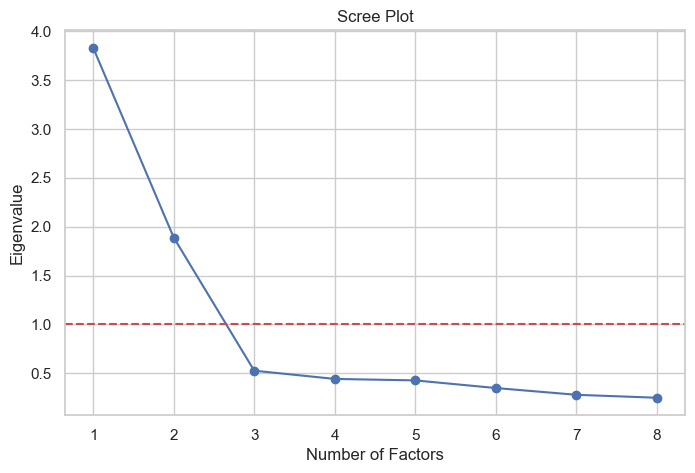

固有値: [3.83 1.89 0.53 0.44 0.43 0.35 0.28 0.25]


In [5]:
# 因子数を変数の数だけ設定して仮実行
fa = FactorAnalyzer(n_factors=len(df.columns), rotation=None)
fa.fit(df)

# 固有値（Eigenvalues）の取得
ev, v = fa.get_eigenvalues()

# スクリープロットの描画
plt.figure(figsize=(8, 5))
plt.scatter(range(1, df.shape[1]+1), ev)
plt.plot(range(1, df.shape[1]+1), ev)
plt.title('Scree Plot')
plt.xlabel('Number of Factors')
plt.ylabel('Eigenvalue')
plt.axhline(y=1, color='r', linestyle='--') # 基準線（固有値1以上を採用することが多い）
plt.grid(True)
plt.show()

print("固有値:", ev.round(2))
# 通常、固有値が急激に下がってなだらかになる直前、または1以上の数を選びます。
# 今回の設計では「2」または「3」あたりで折れるはずです。

# 因子分析の実行とヒートマップ可視化
因子数を「2」と仮定して実行します。 回転法には promax（斜交回転）を使用します。これは、健康要因同士（肥満とストレス）には相関があることが自然だからです。

In [8]:
import plotly.express as px

# --- 分析パート（前回と同じ）---
# 因子の数を指定（スクリープロットの結果を見て 2 と仮定）
n_factors = 2

# 因子分析の実行 (promax回転)
fa = FactorAnalyzer(n_factors=n_factors, rotation='promax')
fa.fit(df)

# 因子負荷量（Factor Loadings）の取得
loadings = pd.DataFrame(fa.loadings_, 
                        index=df.columns, 
                        columns=[f'Factor{i+1}' for i in range(n_factors)])

# --- 可視化パート (Plotly) ---
fig_heatmap = px.imshow(
    loadings,
    text_auto='.2f',  # 値を小数点2桁で表示
    aspect="auto",
    color_continuous_scale='RdBu_r', # 赤〜青（相関の正負を表現）
    zmin=-1, zmax=1,
    title='Factor Loadings (因子負荷量)'
)

fig_heatmap.update_layout(
    xaxis_title="Factors",
    yaxis_title="Variables",
    width=600,
    height=600
)

fig_heatmap.show()

# 因子の解釈ヒント
print("--- 因子の解釈 ---")
print("赤色が強い箇所 = その因子との正の相関が強い")
print("青色が強い箇所 = その因子との負の相関が強い")

--- 因子の解釈 ---
赤色が強い箇所 = その因子との正の相関が強い
青色が強い箇所 = その因子との負の相関が強い


# 因子得点の算出（個人のスコアリング）

In [9]:
import plotly.graph_objects as go

# --- 計算パート ---
# 因子得点の計算
factor_scores = pd.DataFrame(fa.transform(df), 
                            columns=[f'Factor{i+1}' for i in range(n_factors)])

# 元データと結合
result_df = pd.concat([df, factor_scores], axis=1)

# 因子の命名（ヒートマップの結果を見て適宜変更してください）
# ここでは Factor1=代謝リスク, Factor2=ストレス・血圧リスク と仮定
x_axis_label = 'Score_Metabolic(運動不足)'
y_axis_label = 'Score_Stress(高血圧負荷)'

result_df = result_df.rename(columns={
    'Factor1': x_axis_label,
    'Factor2': y_axis_label
})

# --- 可視化パート (Plotly) ---
fig_scatter = px.scatter(
    result_df, 
    x=x_axis_label, 
    y=y_axis_label,
    # ホバーした時に元の健診データを表示（分析に便利！）
    hover_data=['BMI', '収縮期血圧(SBP)', '空腹時血糖(FPG)'], 
    title='受診者の因子スコア分布（リスクマップ）',
    opacity=0.7
)

# 中心線（0,0）を追加して象限をわかりやすくする
fig_scatter.add_vline(x=0, line_width=1, line_dash="dash", line_color="gray")
fig_scatter.add_hline(y=0, line_width=1, line_dash="dash", line_color="gray")

# レイアウト調整
fig_scatter.update_layout(
    xaxis_title=x_axis_label,
    yaxis_title=y_axis_label,
    width=800,
    height=600,
    template='plotly_white'
)

# 象限の注釈（必要に応じて）
fig_scatter.add_annotation(x=2, y=2, text="高リスク群", showarrow=False, font=dict(color="red"))
fig_scatter.add_annotation(x=-2, y=-2, text="健康群", showarrow=False, font=dict(color="green"))

fig_scatter.show()

### ノート
* 因子負荷量 (Loading): 変数と因子の相関係数のようなもの。絶対値が0.4以上あれば関係が強いと見なします。
* 回転 (Rotation): promax は斜交回転で、因子間の相関を許容します（現実的）。varimax は直交回転で、因子間が無相関であると仮定します。
* 解釈: 出力されたヒートマップを見て、「因子1はBMIと血糖値が高いから『メタボ因子』だな」と人間が意味付けを行います。